通过多项式拟合来来探索 模型选择 + 过拟合和欠拟合

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
from IPython import display

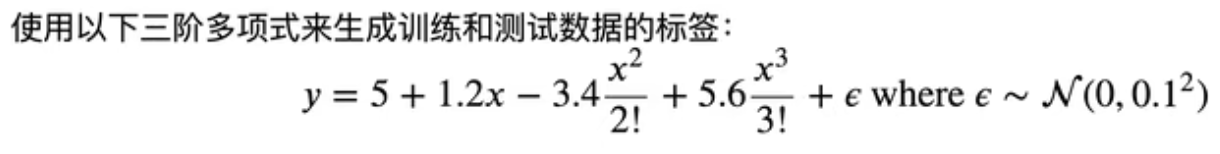

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)

poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))

for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape) 

这段代码是为了生成多项式回归的合成数据。让我们逐步解释代码：

```python
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
```
- `max_degree`：指定多项式的最高次数。
- `n_train` 和 `n_test`：定义训练和测试样本的数量。
- `true_w`：初始化一个长度为 `max_degree` 的零数组，将前四个系数设置为特定的值。

```python
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
```
- `features`：从正态分布中生成形状为 `(n_train + n_test, 1)` 的随机样本，创建一个特征数组。
- `np.random.shuffle(features)`：对特征进行洗牌，以随机顺序排列。

```python
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
```
- `poly_features`：通过将原始特征提升到 0 到 `max_degree - 1` 次幂，计算多项式特征。

```python
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
```
- 通过使用伽马函数（`math.gamma`）除以每一列对应次数的阶乘，对多项式特征进行归一化。

```python
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)
```
- `labels`：通过将归一化的多项式特征与真实系数进行点乘得到标签。
- 添加标准差为 0.1 的正态分布随机噪声，以模拟真实世界的情况。

总的来说，这段代码生成了用于多项式回归的合成数据。它通过在随机输入数据上创建多项式特征，应用真实系数生成标签，并添加一些随机噪声来模拟真实场景。这种类型的合成数据常用于测试和实验多项式回归模型。

在NumPy中，`reshape` 函数用于改变数组的形状。在这里，`reshape(1, -1)` 的意思是将数组的形状调整为一个行向量（1行）且列数自动推断。

具体解释：
- 第一个参数是指定新数组的行数，这里是1，表示我们想要得到一个行向量。
- 第二个参数是列数，但当使用`-1`时，NumPy会根据数组的总元素数自动计算列数，以保持原始数组中的所有元素。

在这个代码片段中，`reshape(1, -1)` 的目的是将原始数组从一维数组或其他形状调整为一个行向量，而不改变数组中的元素数量。

In [3]:
true_w, features, poly_features, labels = [
        torch.tensor(x, dtype=torch.float32)
        for x in [true_w, features, poly_features, labels]
    ]

这行代码使用了列表解析和 PyTorch 的 `torch.tensor` 函数，其目的是将四个变量（`true_w`, `features`, `poly_features`, `labels`）转换为 PyTorch 的张量（`torch.tensor` 类型）并分别赋值给相应的变量。

具体解释：

```python
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]
```

- `for x in [true_w, features, poly_features, labels]`: 遍历包含四个元素的列表，列表中的每个元素（`true_w`, `features`, `poly_features`, `labels`）都将被赋给变量 `x`。

- `torch.tensor(x, dtype=torch.float32)`: 对每个元素 `x` 使用 `torch.tensor` 函数进行转换，将其转换为 PyTorch 的张量（`torch.tensor` 类型），同时指定数据类型为 `torch.float32`。

- 最终，四个转换后的 PyTorch 张量被分别赋给了 `true_w`, `features`, `poly_features`, `labels` 这四个变量。

这样的转换是为了确保数据在 PyTorch 中的张量类型一致，并通常在进行深度学习模型的训练和计算时使用。 PyTorch 张量是 PyTorch 中处理数据的基本数据结构。

看看前两个数据

In [4]:
features[:2], poly_features[:2,:], labels[:2]

(tensor([[ 0.6908],
         [-0.9952]]),
 tensor([[ 1.0000e+00,  6.9080e-01,  2.3860e-01,  5.4941e-02,  9.4883e-03,
           1.3109e-03,  1.5093e-04,  1.4894e-05,  1.2861e-06,  9.8716e-08,
           6.8193e-09,  4.2825e-10,  2.4653e-11,  1.3100e-12,  6.4639e-14,
           2.9768e-15,  1.2852e-16,  5.2225e-18,  2.0043e-19,  7.2871e-21],
         [ 1.0000e+00, -9.9521e-01,  4.9522e-01, -1.6428e-01,  4.0874e-02,
          -8.1357e-03,  1.3495e-03, -1.9186e-04,  2.3867e-05, -2.6392e-06,
           2.6266e-07, -2.3764e-08,  1.9708e-09, -1.5088e-10,  1.0725e-11,
          -7.1160e-13,  4.4262e-14, -2.5912e-15,  1.4326e-16, -7.5042e-18]]),
 tensor([5.1387, 1.1635]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

这段代码定义了一个用于评估模型损失的函数 `evaluate_loss`。让我们逐行解释：

```python
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(x)
        y = y.shape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]
```

- `def evaluate_loss(net, data_iter, loss)`: 定义了一个函数 `evaluate_loss`，接受三个参数，分别是神经网络模型 `net`、数据迭代器 `data_iter` 和损失函数 `loss`。

- `metric = d2l.Accumulator(2)`: 创建了一个累加器 `metric`，用于累加损失函数的总和和元素数量。这里假设存在一个名为 `d2l.Accumulator` 的工具类，该类用于累加数值。

- `for X, y in data_iter:`: 遍历数据迭代器，每次迭代获取一个批次的输入特征 `X` 和标签 `y`。

- `out = net(x)`: 使用神经网络模型 `net` 对输入 `X` 进行前向传播，得到预测输出 `out`。

- `y = y.shape(out.shape)`: 调整标签 `y` 的形状，使其与预测输出 `out` 的形状相同。这可能是为了确保它们具有相容的形状，以便进行损失计算。

- `l = loss(out, y)`: 使用损失函数 `loss` 计算预测输出 `out` 与调整后的标签 `y` 之间的损失值。

- `metric.add(l.sum(), l.numel())`: 将当前批次的损失值总和以及损失值的元素数量累加到 `metric` 中。

- `return metric[0] / metric[1]`: 返回平均损失，即所有批次的损失值总和除以元素数量的总和。这是为了获得模型在给定数据上的平均损失值。

请注意，代码中使用了一些未定义的变量和工具类（如 `d2l.Accumulator`），因此确保这些部分的实现在其他地方被正确定义。

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', 
                            ylabel='loss',
                            xlim=[1, num_epochs],
                            ylim=[-100, 100],
                            legend=['train', 'test']
                           )
    
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)
                                    )
                        )
        print('weight:', net[0].weight.data.numpy())
            
    

三阶多项式函数拟合（正态）

weight: [[ 4.974976   1.2219021 -3.4159584  5.531062 ]]


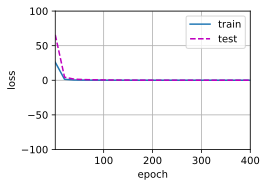

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
     labels[:n_train], labels[n_train:]
     )

线性函数拟合（欠拟合）

weight: [[3.4887555 4.099465 ]]


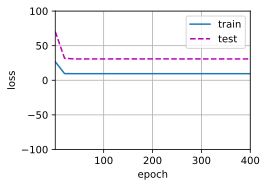

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
     labels[:n_train], labels[n_train:]
     )

高阶多项式函数拟合（过拟合）

weight: [[ 4.8817363   1.4010831  -2.906008    4.717901   -1.569935    1.0484565
  -0.3970004  -0.02839163 -0.20464495 -0.20886926  0.12347382  0.11825722
   0.06265986 -0.06456654  0.21862325  0.11948778 -0.16864482 -0.21134953
   0.17982444 -0.02314733]]


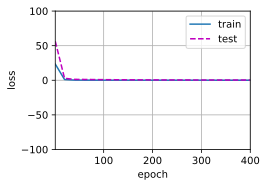

In [10]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
     labels[:n_train], labels[n_train:]
     )